# Processing for 2024 Papau New Guinea landslide displacement time series
Quinn Brencher 

In [11]:
# import packages
import os
import pyproj
pyproj.datadir.set_data_dir('/srv/conda/envs/mintpy/share/proj')
os.environ["PROJ_DATA"]="/srv/conda/envs/mintpy/share/proj"
from glob import glob
import geopandas as gpd
from pathlib import Path
from typing import List, Union
from osgeo import gdal, gdal_array
import numpy as np
import matplotlib.pyplot as plt
import rioxarray
import xarray as xr
import rasterio as rio
import datetime
from datetime import datetime, timedelta
import sys
from mintpy.utils import readfile, writefile, utils as ut, plot
from mintpy.cli import view, tsview, plot_network, plot_transection
from mintpy.view import prep_slice, plot_slice
import gc
import pandas as pd
import seaborn as sns
from scipy.stats import linregress
from rasterio.enums import Resampling
from matplotlib.colors import LogNorm
import contextily as cx
sns.set_theme()

In [2]:
# set up paths, directories, and variables for this specific dam
data_path = '/home/jovyan/repos/papau_new_guinea_ls_2024/data'
des_burst1 = '133_284637_IW2'

des_burst1_path = f'{data_path}/insar/{des_burst1}'

feature_name = 'ls'
proc_path = f'/home/jovyan/repos/papau_new_guinea_ls_2024/nbs'

# define reference point, [y, x]
reference_point = [4496863.4, 600588.6]

# define crs 
crs = 32754

## Prepare input data

In [3]:
# read in feature polygon
feature_fn = f'../mapping/polygons/landslide.shp'
feature_gdf = gpd.read_file(feature_fn)
feature_gdf = feature_gdf.to_crs(crs) # reproject in case of mistake

# # load in moving area polygon
# moving_fn = f'../mapping/polygons/landslide_moving.shp'
# moving_gdf = gpd.read_file(moving_fn)

# # load in reference area polygon
# reference_fn = f'../mapping/polygons/reference_area.shp'
# reference_gdf = gpd.read_file(reference_fn)

# # load in stable area polygon
# stable_fn = f'../mapping/polygons/stable_area.shp'
# stable_gdf = gpd.read_file(stable_fn).to_crs(crs)

# # load in water mask
# water_fn = f'../mapping/polygons/water_mask.shp'
# water_gdf = gpd.read_file(water_fn).to_crs(crs)

# pad dam bounds by 5 km 
padding = 5000
aoi_extent = [feature_gdf.bounds.minx.item()-padding,
               feature_gdf.bounds.maxy.item()+padding,
               feature_gdf.bounds.maxx.item()+padding,
               feature_gdf.bounds.miny.item()-padding]

In [4]:
def clip_hyp3_products_to_common_overlap(data_path: Union[str, Path], overlap: List[float]) -> None:    
    files_for_mintpy = ['_rng_off.tif', '_snr.tif', '_conncomp.tif', '_corr.tif', '_unw_phase.tif', '_dem.tif', '_lv_theta.tif', '_lv_phi.tif']
    for extension in files_for_mintpy:
        print(f'working on {extension}') 
        for file in data_path.rglob(f'*{extension}'):
            dst_file = file.parent / f'{file.stem}_{feature_name}{file.suffix}'
            gdal.Translate(destName=str(dst_file), srcDS=str(file), projWin=overlap)

In [5]:
# clip igram products to dam aoi
clip_hyp3_products_to_common_overlap(Path(des_burst1_path), aoi_extent)

working on _rng_off.tif
working on _snr.tif
working on _conncomp.tif


/srv/conda/envs/mintpy/lib/python3.11/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


working on _corr.tif
working on _unw_phase.tif
working on _dem.tif
working on _lv_theta.tif
working on _lv_phi.tif


## Examine coherence time series for dam

In [6]:
# functions to load interferogram tifs to xarray
def xr_read_geotif(geotif_file_path, masked=True):
    """
    Reads in single or multi-band GeoTIFF as dask array.
    Inputs
    ----------
    GeoTIFF_file_path : GeoTIFF file path
    Returns
    -------
    ds : xarray.Dataset
        Includes rioxarray extension to xarray.Dataset
    """

    da = rioxarray.open_rasterio(geotif_file_path, masked=True)

    # Extract bands and assign as variables in xr.Dataset()
    ds = xr.Dataset()
    for i, v in enumerate(da.band):
        da_tmp = da.sel(band=v)
        da_tmp.name = "band" + str(i + 1)

        ds[da_tmp.name] = da_tmp

    # Delete empty band coordinates.
    # Need to preserve spatial_ref coordinate, even though it appears empty.
    # See spatial_ref attributes under ds.coords.variables used by rioxarray extension.
    del ds.coords["band"]

    # Preserve top-level attributes and extract single value from value iterables e.g. (1,) --> 1
    ds.attrs = da.attrs
    for key, value in ds.attrs.items():
        try:
            if len(value) == 1:
                ds.attrs[key] = value[0]
        except TypeError:
            pass

    return ds

def hyp3_to_xarray(hyp3_dir, file_type='corr', epsg=crs, interpolate_na=False):
    
    dirs = os.listdir(hyp3_dir) #list generated interferograms
    datasets = []
    acquisition_list = []
    
    for idir in dirs:
        tif_path = glob(f'{hyp3_dir}/{idir}/*/*{file_type}.tif')[0]
        tif_fn = os.path.split(tif_path)[-1]
        dates = f'{tif_fn[14:22]}_{tif_fn[23:31]}' #parse filename for interferogram dates
        start_date = datetime.strptime(dates[:8], '%Y%m%d')
        end_date = datetime.strptime(dates[-8:], '%Y%m%d')
        t_baseline = end_date - start_date
        
        src = xr_read_geotif(tif_path, masked=False) #read product to xarray ds
        src = src.assign_coords({"dates": dates})
        src = src.expand_dims("dates")
        
        src = src.assign_coords(start_date = ('dates', [start_date]))
        src = src.assign_coords(end_date = ('dates', [end_date]))
        src = src.assign_coords(t_baseline = ('dates', [t_baseline]))
        
        src = src.rename({'band1':file_type})
        src = src.rio.write_crs(epsg)
        # in future, should get spatial baseline, flight dir, and orbit from metadata
        
        if interpolate_na == True:
            src = src.interpolate_na(dim='x', method='linear').fillna(value=0)
        
        datasets.append(src)
        #print(src[file_type].shape, src.dates.item())
       
    ds = xr.concat(datasets, dim="dates", combine_attrs="no_conflicts") #create dataset
    ds = ds.sortby('dates')

    return ds 

In [7]:
des1_corr_ds = hyp3_to_xarray(des_burst1_path, file_type=f'corr_{feature_name}')

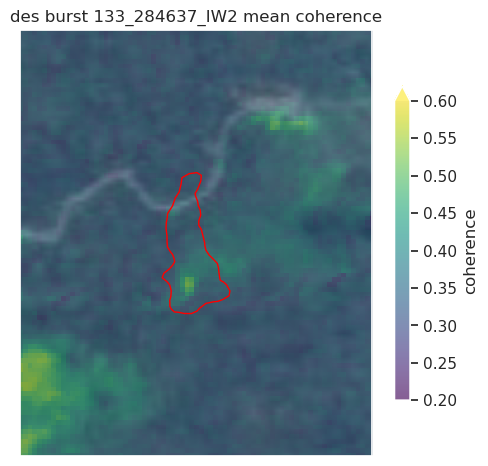

In [35]:
# plot mean spatial coherence
padding = 4400

f, ax = plt.subplots(1, 1, figsize=(5, 5), sharex=True, sharey=True)

des1_corr_ds[f'corr_{feature_name}'].mean(dim='dates').plot.imshow(ax=ax, add_colorbar=False)
cx.add_basemap(ax=ax, source='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', crs=crs)
des1_corr_ds[f'corr_{feature_name}'].mean(dim='dates').plot.imshow(ax=ax, vmin=0.2, vmax=0.6, cbar_kwargs= {'label':'coherence', 'shrink':0.7}, alpha=0.6)
feature_gdf.plot(ax=ax, edgecolor='red', facecolor='none')
# moving_gdf.plot(ax=ax[1], edgecolor='red', facecolor='none')
# stable_gdf.plot(ax=ax[1], edgecolor='blue', facecolor='none')
# reference_gdf.plot(ax=ax[1], edgecolor='white', facecolor='none')
# ax.scatter(reference_point[1], reference_point[0], c='k', s=5)
ax.set_title(f'des burst {des_burst1} mean coherence')
ax.set_aspect('equal')
ax.set_xlim(aoi_extent[0]+padding, aoi_extent[2]-padding)
ax.set_ylim(aoi_extent[3]+padding, aoi_extent[1]-padding)
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')

f.tight_layout()
plt.savefig(f'../figs/{feature_name}_coherence_map.png', dpi=300)

In [24]:
# save coherence maps
des1_corr_ds[f'corr_{feature_name}'].mean(dim='dates').rio.to_raster(f'des{des_burst1}_mean_coherence.tif')

In [25]:
des1_corr_ds_12day = des1_corr_ds.where(des1_corr_ds.t_baseline.dt.days == 12 , drop=True)

In [36]:
des1_corr_ds_12day[f'corr_{feature_name}'].mean(dim='dates').rio.to_raster(f'des{des_burst1}_mean_12day_coherence.tif')

In [26]:
# clip datasets to polygon
des1_feature_corr_ds = des1_corr_ds.rio.clip(feature_gdf.geometry.values, crs=feature_gdf.crs, drop=True)
des1_feature_corr_ds = des1_feature_corr_ds.assign_coords(middle_date = ('dates', (des1_feature_corr_ds.t_baseline/2+des1_feature_corr_ds.start_date).data))

# # clip datasets to moving polygon

# des1_feature_corr_ds = des1_corr_ds.rio.clip(moving_gdf.geometry.values, crs=moving_gdf.crs, drop=True)
# des1_feature_corr_ds = des1_feature_corr_ds.assign_coords(middle_date = ('dates', (des1_feature_corr_ds.t_baseline/2+des1_feature_corr_ds.start_date).data))

# # clip datasets to stable polygon

# des_stable_corr_ds = des_corr_ds.rio.clip(stable_gdf.geometry.values, crs=stable_gdf.crs, drop=True)
# des_stable_corr_ds = des_stable_corr_ds.assign_coords(middle_date = ('dates', (des_stable_corr_ds.t_baseline/2+des_stable_corr_ds.start_date).data))

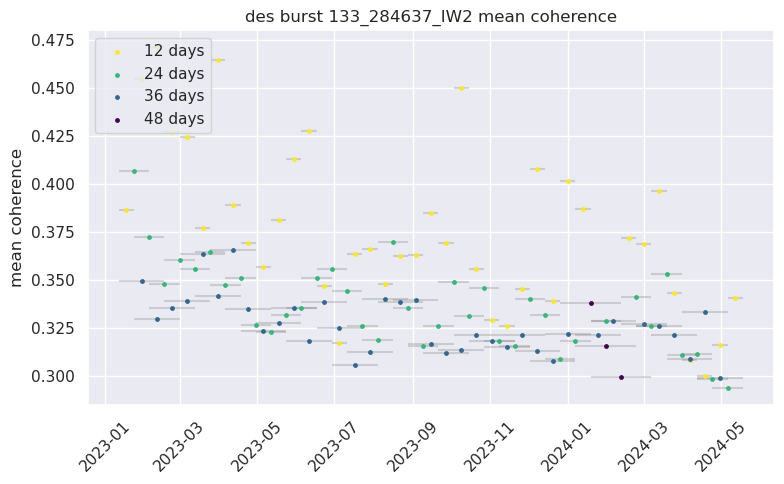

In [30]:
burst_list = [des1_corr_ds]
t_baselines = np.empty(0)
for i, burst in enumerate(burst_list):
    t_baselines = np.union1d(t_baselines, burst.t_baseline.dt.days.values)

# plot seasonal changes in coherence 
colors = plt.cm.viridis_r(np.linspace(0, 1, len(t_baselines)))

f, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, days in enumerate(t_baselines):
  
        if i == 0:
            ax.hlines(y=des1_feature_corr_ds[f'corr_{feature_name}'].mean(dim=['x', 'y']),
                     xmin=des1_feature_corr_ds.start_date,
                     xmax=des1_feature_corr_ds.end_date,
                     color='gray', alpha=0.3, zorder=1)
        
        ax.scatter(des1_feature_corr_ds.middle_date[des1_feature_corr_ds.t_baseline.dt.days == days],
                      des1_feature_corr_ds[f'corr_{feature_name}'].mean(dim=['x', 'y'])[des1_feature_corr_ds.t_baseline.dt.days == days],
                      color=colors[i],
                      s=6,
                      label=f'{int(days)} days')

      
        ax.set_ylabel('mean coherence')
        # ax[j].set_xlabel('date')
        ax.set_title(f'des burst {des_burst1} mean coherence')
        ax.legend(loc='upper left')
        ax.tick_params('x', labelrotation=45)
f.tight_layout()
plt.savefig(f'../figs/{feature_name}_coherence_ts.png', dpi=300)

In [ ]:
des1_feature_corr_ds.corr_ls.mean(dim=['x', 'y']).idxmax()

In [ ]:
# interpret plot
# if offsets will be needed to bridge summer gap, set use_offsets = True
use_offsets = False

In [ ]:
# asc_acquisitions = xr.DataArray(np.union1d(asc_corr_ds.start_date, asc_corr_ds.end_date))
# des_acquisitions = xr.DataArray(np.union1d(des_corr_ds.start_date, des_corr_ds.end_date))